# GeoCache: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [394]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [395]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [396]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier00.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [397]:
df_Wine.shape

(3304, 25)

In [398]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [399]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [400]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [401]:
df_GeoCache.shape

(1228, 8)

In [402]:
df_Flag.shape

(19, 3)

In [403]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
1596,2005,95,2003,90.0,19,Barnard Griffin,Merlot Columbia Valley,Red,Merlot,NaN,...,2005.0,2010.0,"Fresh, generous and appealing for its pretty c...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
687,2014,86,2012,90.0,23,Pali Wine Co.,Pinot Noir Santa Barbara County Huntington,Red,Pinot Noir,NaN,...,2014.0,2022.0,"Notably floral and spicy, with firm tannins am...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
688,2014,87,2011,91.0,23,Firriato,Sicilia Santagostino Baglio Soria Red,Red,Blend,Nero d'Avola and Syrah,...,2014.0,2024.0,Aromas and flavors of bacon fat and mesquite s...,Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
1057,2010,56,2007,91.0,21,Concha y Toro,Cabernet Sauvignon Puente Alto Marqués de Casa...,Red,Cabernet Sauvignon,NaN,...,2010.0,2012.0,"Rock-solid, with dark currant, fig and blackbe...",Hierarchy_00,Chile,Chile,"(-31.7613365, -71.3187697, 0.0)",-31.761336,-71.318770,0.0
1658,2004,57,2000,95.0,35,Chateau Dereszla,Tokaji Aszú 5 Puttonyos,Dessert & Fortified,Blend,Tokaji Blend,...,2004.0,2020.0,"Gorgeous, silky and harmonious, offering orang...",Hierarchy_00,Hungary,Magyarország,"(47.1817585, 19.5060937, 0.0)",47.181759,19.506094,0.0
317,2017,18,2015,92.0,25,Bodega Colomé,Malbec Salta,Red,Malbec,NaN,...,2017.0,2022.0,"Refined and rich-tasting, with effusive minera...",Hierarchy_00,Argentina,Argentina,"(-34.9964963, -64.9672817, 0.0)",-34.996496,-64.967282,0.0
1114,2009,13,2006,95.0,52,Fattoria di Felsina,Toscana Fontalloro,Red,Sangiovese,NaN,...,2012.0,NaN,"Chocolate, blackberry and black cherry aromas ...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0
1961,2001,60,1999,94.0,63,Beaux Frères,Pinot Noir Yamhill County The Beaux Frères Vin...,Red,Pinot Noir,NaN,...,2001.0,2009.0,"Bright, supple and open-textured, offering dis...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
2107,1999,6,1997,96.0,50,Pahlmeyer,Chardonnay Napa Valley,White,Chardonnay,NaN,...,1999.0,2004.0,"Ultrarich and ultraripe Chardonnay. A creamy, ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0
533,2015,33,2014,91.0,17,Pewsey Vale,Riesling Eden Valley Dry,White,Riesling,NaN,...,2019.0,2030.0,"Taut, sleek, polished and distinctively spicy,...",Hierarchy_00,Australia,Australia,"(-24.7761086, 134.755, 0.0)",-24.776109,134.755000,0.0


## Review Year versus Vintage Year, for non-NV wines

In [404]:
# Remove Non-Vintage (NV) wines from df_Wine

df_Wine_V = df_Wine[
    (df_Wine.Vintage != 'NV')
]

df_Wine_V.shape

(3248, 25)

In [405]:
# Calculate difference between Review Year and Vintage Year
df_Wine_V['Review_vs_Vintage'] = df_Wine_V['Review_Year'].astype(float) - df_Wine_V['Vintage'].astype(float)

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [406]:
df_Wine_V.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude,Review_vs_Vintage
2469,1996,68,1993,91.0,22,Chateau St. Jean,Cabernet Sauvignon Sonoma County Cinq Cépages,Red,Cabernet Sauvignon,NaN,...,NaN,"An elegant style that delivers a ripe, intense...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,3.0
3050,1990,48,1987,93.0,20,Mazzocco,Cabernet Sauvignon Alexander Valley Claret Style,Red,Cabernet Sauvignon,NaN,...,NaN,"Delicious layers of complex, concentrated and ...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,3.0
3028,1990,26,1988,94.0,26,Kistler,Chardonnay Sonoma Valley Kistler Vineyard,White,Chardonnay,NaN,...,NaN,"Oozing with rich, opulent, delicious pear, hon...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,2.0
1803,2002,2,1999,95.0,70,Chateau St. Jean,Cabernet Sauvignon Sonoma County Cinq Cépages,Red,Cabernet Sauvignon,NaN,...,2014.0,"Gorgeous Cabernet, offering a mix of ripe, ric...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,3.0
1216,2008,15,2006,96.0,110,Tenuta Sette Ponti,Toscana Oreno,Red,Blend,"Cabernet Sauvignon, Merlot and Sangiovese",...,NaN,"Shows loads of black licorice, blackberry and ...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,2.0
1122,2009,21,2007,93.0,29,Neyers,Chardonnay Carneros,White,Chardonnay,NaN,...,2012.0,"Complex aromas of smoke, fig and citrus fold o...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,2.0
2285,1998,37,1995,91.0,20,Argyle,Chardonnay Willamette Valley Reserve,White,Chardonnay,NaN,...,2002.0,"Bright layers of pear, citrus and quince unfol...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,3.0
582,2015,81,2013,91.0,27,Bodega Luigi Bosca,Malbec Luján de Cuyo Single Vineyard,Red,Malbec,NaN,...,2021.0,"Decadently spiced, with intense dark chocolate...",Hierarchy_00,Argentina,Argentina,"(-34.9964963, -64.9672817, 0.0)",-34.996496,-64.967282,0.0,2.0
1391,2007,90,2005,90.0,12,Bodegas Borsao,Garnacha Campo de Borja Tres Picos,Red,Grenache | Garnacha,NaN,...,2010.0,"Vivid and concentrated, yet still focused and ...",Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0,2.0
688,2014,87,2011,91.0,23,Firriato,Sicilia Santagostino Baglio Soria Red,Red,Blend,Nero d'Avola and Syrah,...,2024.0,Aromas and flavors of bacon fat and mesquite s...,Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,3.0


In [407]:
# Average difference between Review and Vintage (years) by Wine Style - All Years
df_RV_All = pd.DataFrame({'Review_vs_Vintage' : df_Wine_V.groupby(['Wine_Style'])['Review_vs_Vintage'].mean()}).reset_index()
df_RV_All

,Wine_Style,Review_vs_Vintage
0,Dessert & Fortified,3.628571
1,Red,3.056694
2,Rosé | Rosado,1.000000
3,Sparkling,6.913043
4,White,1.998795


In [408]:
# Average difference between Review and Vintage (years) by Wine Style - By Year
df_RV_ByYear = pd.DataFrame({'Review_vs_Vintage' : df_Wine_V.groupby(['Review_Year', 'Wine_Style'])['Review_vs_Vintage'].mean()}).reset_index()
df_RV_ByYear.sample(10)

,Review_Year,Wine_Style,Review_vs_Vintage
80,2010,Red,2.847222
8,1990,Red,3.861538
24,1995,Dessert & Fortified,3.000000
0,1988,Dessert & Fortified,5.000000
96,2014,Dessert & Fortified,4.000000
48,2001,Red,3.042254
110,2017,Red,2.681159
33,1997,Red,2.789474
78,2009,White,2.416667
16,1992,Sparkling,9.000000


### Visualization

In [409]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

Text(0.5, 1.1, 'Average Length between Vintage Year and Review Year')

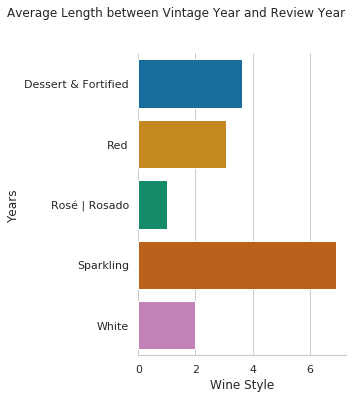

In [410]:
# bar plot of summary data

g = sns.catplot(
    data = df_RV_All,
    kind = 'bar',
    y = 'Wine_Style',
    x = 'Review_vs_Vintage',
)

g.despine(left = True)
g.set_axis_labels('Wine Style', 'Years')

plt.suptitle('Average Length between Vintage Year and Review Year', y = 1.1)

In [411]:
# explore the sparkling wines further.

# subset the dataset to only sparkling wines

df_Wine_Sparkling = df_Wine_V[
    (df_Wine.Wine_Style == 'Sparkling')
]

# Average difference between Review and Vintage (years) by Wine Style - By Year
df_Sparkling = pd.DataFrame({'Review_vs_Vintage' : df_Wine_Sparkling.groupby(['Address'])['Review_vs_Vintage'].mean()}).reset_index()
df_Sparkling.head()

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,Address,Review_vs_Vintage
0,France,7.958333
1,Italy,2.000000
2,Spain,4.000000
3,USA,6.277778


Text(0.5, 1.1, 'Sparkling Wines\nAverage Length between Vintage Year and Review Year by Country')

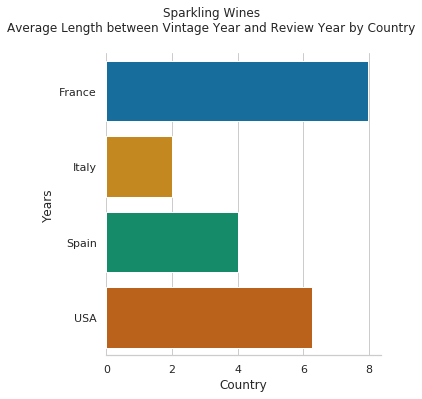

In [412]:
# bar plot of summary data

g = sns.catplot(
    data = df_Sparkling,
    kind = 'bar',
    y = 'Address',
    x = 'Review_vs_Vintage',
)

g.despine(left = True)
g.set_axis_labels('Country', 'Years')

plt.suptitle('Sparkling Wines\nAverage Length between Vintage Year and Review Year by Country', y = 1.1)

## Wait to Drink? Drink from Year versus Review Year

In [413]:
# Filter df_Wine where Vintage is not NV
df_Wine_BDF = df_Wine_V[
    (df_Wine['Best_Drink_from'].isnull() == False )
]

df_Wine_BDF.shape

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(2950, 26)

In [414]:
# Calculate difference between Best Drink From and Review Year
df_Wine_BDF['DrinkFrom_vs_Review'] = df_Wine_BDF['Best_Drink_from'].astype(float) - df_Wine_BDF['Review_Year'].astype(float)

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [415]:
df_Wine_BDF.head()

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Review,Hierarchy,Address,loc,point,lat,long,altitude,Review_vs_Vintage,DrinkFrom_vs_Review
0,2020,1,2010,96.0,139,Bodegas Marqués de Murrieta,Rioja Castillo Ygay Gran Reserva Especial,Red,Blend,Tempranillo and Mazuelo.,...,"Maturing well, this round red is a lovely exam...",Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0,10.0,0.0
1,2020,2,2018,95.0,85,Aubert,Pinot Noir Sonoma Coast UV Vineyard,Red,Pinot Noir,NaN,...,"Powerful and structured, with minerally richne...",Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,2.0,1.0
2,2020,3,2015,97.0,90,San Filippo,Brunello di Montalcino Le Lucére,Red,Brunello di Montalcino,NaN,...,"Effusive aromas of black currant, blueberry, v...",Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,5.0,3.0
3,2020,4,2016,96.0,135,Mayacamas,Cabernet Sauvignon Mount Veeder,Red,Cabernet Sauvignon,NaN,...,This distinctive red throws a lot of wild sage...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,4.0,2.0
4,2020,5,2016,96.0,90,Domaine de la Vieille Julienne,Châteauneuf-du-Pape Les Trois Sources,Red,Châteauneuf-du-Pape,NaN,...,"A lush, ripe style, with açaí berry, blueberry...",Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0,4.0,2.0


In [416]:
df_Wine_BDFSummStyle = df_Wine_BDF[['Review_vs_Vintage','DrinkFrom_vs_Review','Wine_Style']].groupby('Wine_Style').mean()
df_Wine_BDFSummStyle['Total'] = df_Wine_BDFSummStyle['Review_vs_Vintage'] + df_Wine_BDFSummStyle['DrinkFrom_vs_Review']
df_Wine_BDFSummStyle

,Review_vs_Vintage,DrinkFrom_vs_Review,Total
Wine_Style,,,
Dessert & Fortified,3.600000,5.538462,9.138462
Red,3.024859,1.577861,4.602720
Rosé | Rosado,1.000000,0.000000,1.000000
Sparkling,7.441176,0.352941,7.794118
White,1.969014,0.295775,2.264789


In [417]:
# Determine index type of dataframe
df_Wine_BDFSummCountry = df_Wine_BDF[['Review_vs_Vintage','DrinkFrom_vs_Review','Address','Wine_Style']].groupby(['Wine_Style','Address']).mean()
df_Wine_BDFSummCountry.index

MultiIndex(levels=[['Dessert & Fortified', 'Red', 'Rosé | Rosado', 'Sparkling', 'White'], ['Argentina', 'Australia', 'Austria', 'Canada', 'Chile', 'France', 'Germany', 'Greece', 'Hungary', 'Israel', 'Italy', 'New Zealand', 'Portugal', 'South Africa', 'Spain', 'USA', 'Uruguay']],
           codes=[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 5, 8, 12, 13, 15, 0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 5, 15, 5, 10, 14, 15, 0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]],
           names=['Wine_Style', 'Address'])

In [418]:
# reset the index of the dataframe
df_Wine_BDFSummCountry = df_Wine_BDFSummCountry.reset_index()
# df_Wine_BDFSummCountry['Total'] = df_Wine_BDFSummCountry['Review_vs_Vintage'] + df_Wine_BDFSummCountry['DrinkFrom_vs_Review']
# df_Wine_BDFSummCountry['Axis'] = df_Wine_BDFSummCountry['Wine_Style'] + ' - ' + df_Wine_BDFSummCountry['Address']
df_Wine_BDFSummCountry

,Wine_Style,Address,Review_vs_Vintage,DrinkFrom_vs_Review
0,Dessert & Fortified,Canada,2.000000,0.000000
1,Dessert & Fortified,France,3.400000,2.750000
2,Dessert & Fortified,Hungary,4.875000,0.000000
3,Dessert & Fortified,Portugal,3.382353,8.882353
4,Dessert & Fortified,South Africa,6.000000,1.000000
5,Dessert & Fortified,USA,4.000000,2.000000
6,Red,Argentina,2.290909,0.290909
7,Red,Australia,2.618056,1.055556
8,Red,Austria,3.000000,0.000000
9,Red,Chile,2.945455,0.200000


In [419]:
# write a function to graph several stacked bar plots

def barh_plot(wine_style, left, right, maxyear, label):
    df = df_Wine_BDFSummCountry[
        (df_Wine_BDFSummCountry['Wine_Style'] == wine_style )
    ]
    
    A = np.array(df['Wine_Style'])
    N = len(A)
    
    dim = (10, 8)
    fig, ax = plt.subplots(figsize = dim)

    # x locations for the groups
    ind = np.arange(N)

    width = 0.35

    # Plot the totals
    p1 = plt.barh(ind, df[left], width)
    p2 = plt.barh(ind, df[right], width, left = df[left])

    plt.xlabel('Average Years')
    plt.xticks(np.arange(0, maxyear, 2))

    plt.yticks(ind, df[label])
    
    plt.title(wine_style + '\nTime from Vintage Year to Review Year, from Review Year to Best to Drink Year')
    
    plt.legend((p1[0], p2[0]), ('Vintage to Review', 'Review to Best to Drink'))


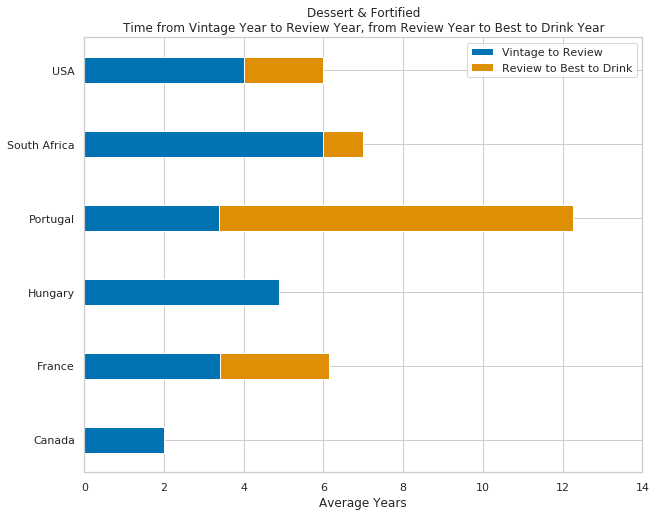

In [420]:
barh_plot(wine_style = 'Dessert & Fortified',
          left = 'Review_vs_Vintage', 
          right = 'DrinkFrom_vs_Review', 
          maxyear = 15, 
          label = 'Address')

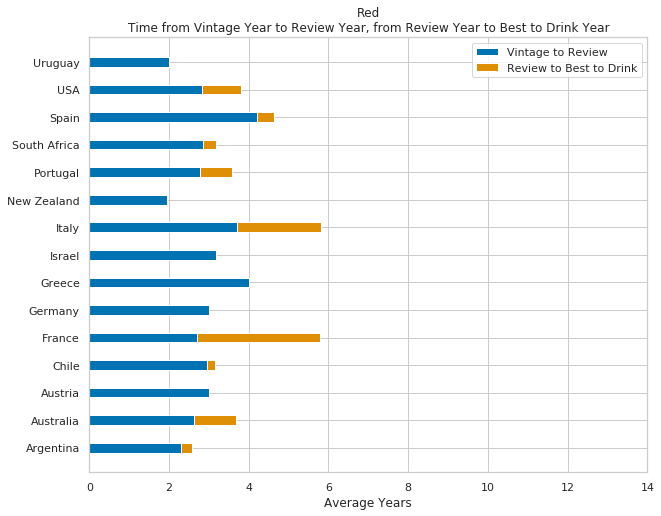

In [421]:
barh_plot(wine_style = 'Red',
          left = 'Review_vs_Vintage', 
          right = 'DrinkFrom_vs_Review', 
          maxyear = 15, 
          label = 'Address')

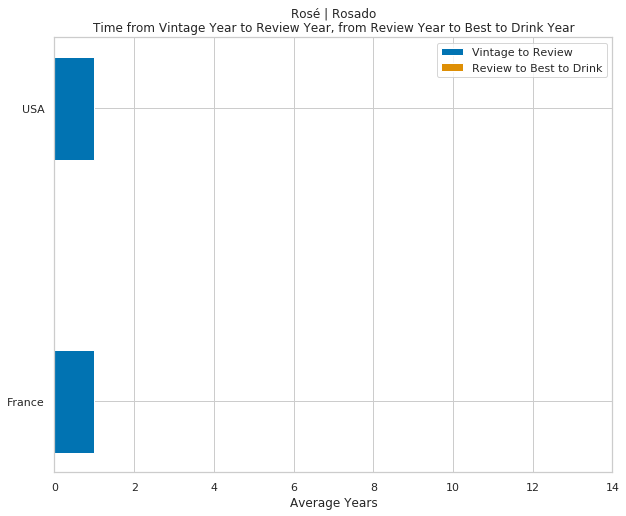

In [422]:
barh_plot(wine_style = 'Rosé | Rosado',
          left = 'Review_vs_Vintage', 
          right = 'DrinkFrom_vs_Review', 
          maxyear = 15, 
          label = 'Address')

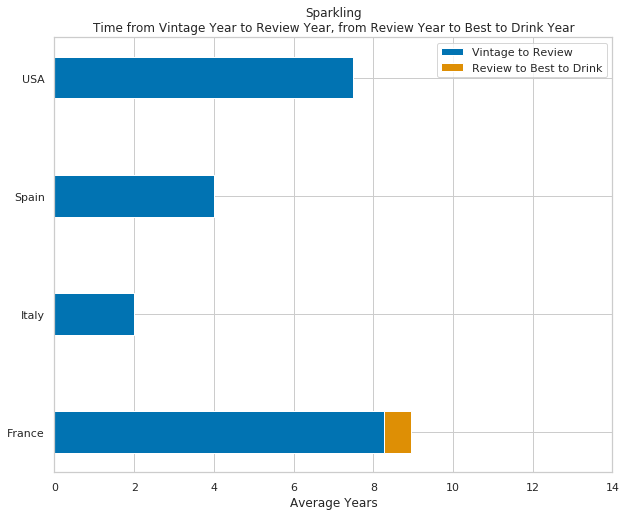

In [423]:
barh_plot(wine_style = 'Sparkling',
          left = 'Review_vs_Vintage', 
          right = 'DrinkFrom_vs_Review', 
          maxyear = 15, 
          label = 'Address')

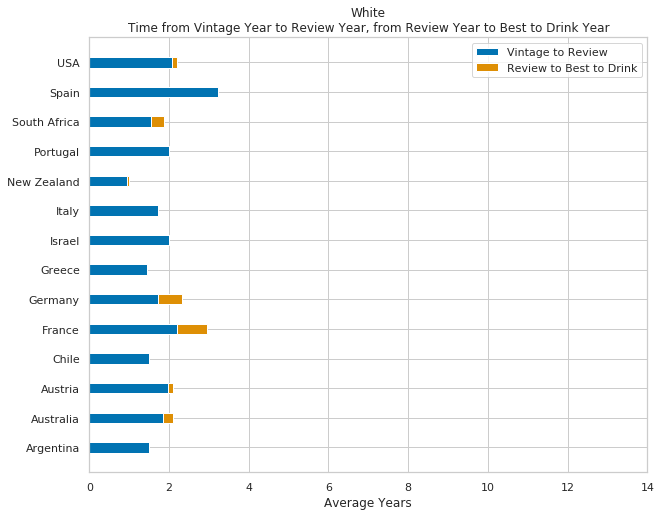

In [424]:
barh_plot(wine_style = 'White',
          left = 'Review_vs_Vintage', 
          right = 'DrinkFrom_vs_Review', 
          maxyear = 15, 
          label = 'Address')

## Drink Until? Drink from Year versus Review Year versus Drink Through Year

In [425]:
# Filter df_Wine where Vintage is not NV
df_Wine_BDT = df_Wine_BDF[
    (df_Wine_BDF['Best_Drink_Through'].isnull() == False )
]

df_Wine_BDT.shape

(2144, 27)

In [426]:
# Calculate difference between Best Drink From and Review Year
df_Wine_BDT['DrinkThru_vs_DrinkFrom'] = df_Wine_BDT['Best_Drink_Through'].astype(float) - df_Wine_BDT['Best_Drink_from'].astype(float)

/home/elizabethwotawa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [427]:
df_Wine_BDT.head()

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Hierarchy,Address,loc,point,lat,long,altitude,Review_vs_Vintage,DrinkFrom_vs_Review,DrinkThru_vs_DrinkFrom
0,2020,1,2010,96.0,139,Bodegas Marqués de Murrieta,Rioja Castillo Ygay Gran Reserva Especial,Red,Blend,Tempranillo and Mazuelo.,...,Hierarchy_00,Spain,España,"(39.3262345, -4.8380649, 0.0)",39.326234,-4.838065,0.0,10.0,0.0,10.0
1,2020,2,2018,95.0,85,Aubert,Pinot Noir Sonoma Coast UV Vineyard,Red,Pinot Noir,NaN,...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,2.0,1.0,5.0
2,2020,3,2015,97.0,90,San Filippo,Brunello di Montalcino Le Lucére,Red,Brunello di Montalcino,NaN,...,Hierarchy_00,Italy,Italia,"(42.6384261, 12.674297, 0.0)",42.638426,12.674297,0.0,5.0,3.0,20.0
3,2020,4,2016,96.0,135,Mayacamas,Cabernet Sauvignon Mount Veeder,Red,Cabernet Sauvignon,NaN,...,Hierarchy_00,USA,United States,"(39.7837304, -100.4458825, 0.0)",39.783730,-100.445882,0.0,4.0,2.0,18.0
4,2020,5,2016,96.0,90,Domaine de la Vieille Julienne,Châteauneuf-du-Pape Les Trois Sources,Red,Châteauneuf-du-Pape,NaN,...,Hierarchy_00,France,France,"(46.603354, 1.8883335, 0.0)",46.603354,1.888333,0.0,4.0,2.0,18.0


In [428]:
# Determine index type of dataframe
df_Wine_BDTSummCountry = df_Wine_BDT[['Review_vs_Vintage','DrinkFrom_vs_Review','DrinkThru_vs_DrinkFrom','Address','Wine_Style']].groupby(['Wine_Style','Address']).mean()
df_Wine_BDTSummCountry.index

MultiIndex(levels=[['Dessert & Fortified', 'Red', 'Rosé | Rosado', 'Sparkling', 'White'], ['Argentina', 'Australia', 'Austria', 'Canada', 'Chile', 'France', 'Germany', 'Greece', 'Hungary', 'Israel', 'Italy', 'New Zealand', 'Portugal', 'South Africa', 'Spain', 'USA', 'Uruguay']],
           codes=[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], [3, 5, 8, 12, 13, 0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 5, 5, 10, 14, 15, 0, 1, 2, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]],
           names=['Wine_Style', 'Address'])

In [429]:
# reset the index of the dataframe
df_Wine_BDTSummCountry = df_Wine_BDTSummCountry.reset_index()
df_Wine_BDTSummCountry['Total'] = df_Wine_BDTSummCountry['Review_vs_Vintage'] + df_Wine_BDTSummCountry['DrinkFrom_vs_Review'] + df_Wine_BDTSummCountry['DrinkThru_vs_DrinkFrom']
df_Wine_BDTSummCountry

,Wine_Style,Address,Review_vs_Vintage,DrinkFrom_vs_Review,DrinkThru_vs_DrinkFrom,Total
0,Dessert & Fortified,Canada,2.000000,0.000000,12.000000,14.000000
1,Dessert & Fortified,France,3.000000,1.454545,20.636364,25.090909
2,Dessert & Fortified,Hungary,4.875000,0.000000,12.375000,17.250000
3,Dessert & Fortified,Portugal,3.833333,9.333333,18.750000,31.916667
4,Dessert & Fortified,South Africa,6.000000,1.000000,14.000000,21.000000
5,Red,Argentina,2.307692,0.192308,4.384615,6.884615
6,Red,Australia,2.466667,0.791667,8.591667,11.850000
7,Red,Austria,3.000000,0.000000,6.000000,9.000000
8,Red,Chile,2.981132,0.207547,4.622642,7.811321
9,Red,France,2.586885,2.016393,10.072131,14.675410


In [454]:
# write a function to graph several stacked bar plots

def barh_plot_3(wine_style, left, mid, right, maxyear, label):
    df = df_Wine_BDTSummCountry[
        (df_Wine_BDTSummCountry['Wine_Style'] == wine_style )
    ]
    
    A = np.array(df['Wine_Style'])
    N = len(A)
    
    dim = (10, 8)
    fig, ax = plt.subplots(figsize = dim)

    # x locations for the groups
    ind = np.arange(N)

    width = 0.35

    # Plot the totals
    p1 = plt.barh(ind, df[left], width)
    p2 = plt.barh(ind, df[mid], width, left = df[left])
    p3 = plt.barh(ind, df[right], width, left = df[left] + df[mid])

    plt.xlabel('Average Years')
    plt.xticks(np.arange(0, maxyear, 2))

    plt.yticks(ind, df[label])
    
    plt.title(wine_style + '\nTime from Vintage Year to Review Year to Best to Drink Year to Drink Through Year')
    
    plt.legend((p1[0], p2[0], p3[0]), ('Vintage to Review', 'Review to Best to Drink', 'Best to Drink to Drink Through'))


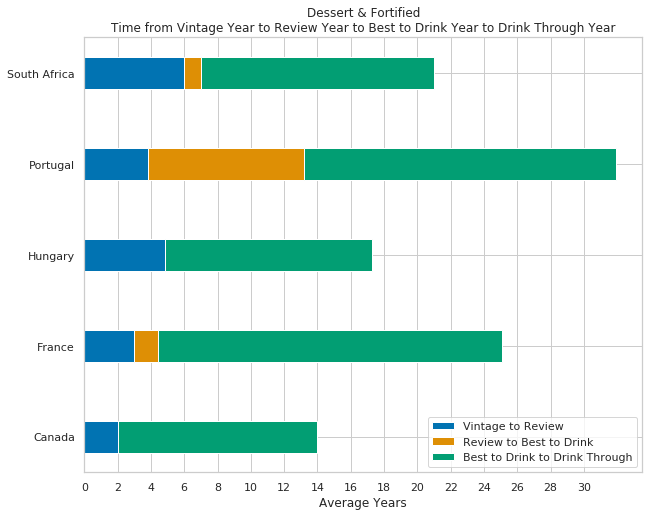

In [455]:
barh_plot_3(wine_style = 'Dessert & Fortified',
          left = 'Review_vs_Vintage', 
          mid = 'DrinkFrom_vs_Review',
          right = 'DrinkThru_vs_DrinkFrom', 
          maxyear = 32, 
          label = 'Address')

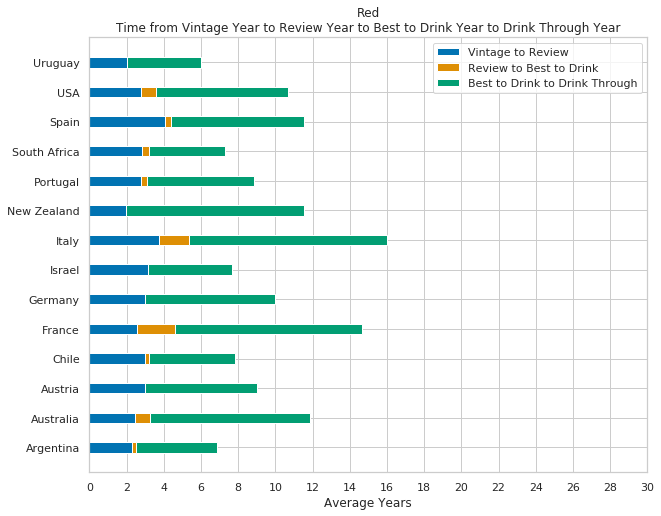

In [456]:
barh_plot_3(wine_style = 'Red',
          left = 'Review_vs_Vintage', 
          mid = 'DrinkFrom_vs_Review',
          right = 'DrinkThru_vs_DrinkFrom', 
          maxyear = 32, 
          label = 'Address')

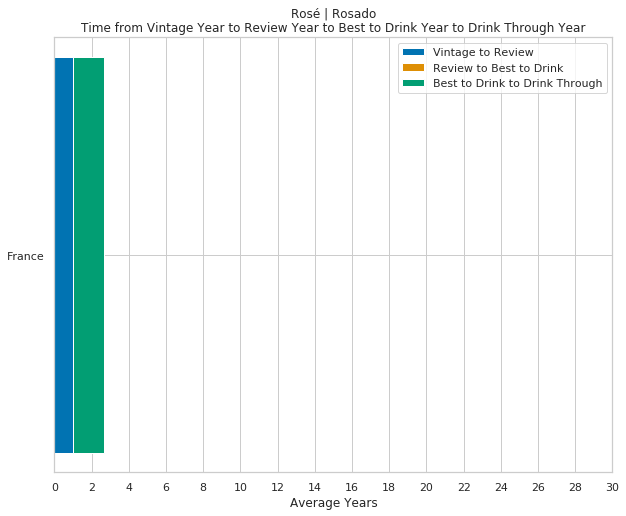

In [457]:
barh_plot_3(wine_style = 'Rosé | Rosado',
          left = 'Review_vs_Vintage', 
          mid = 'DrinkFrom_vs_Review',
          right = 'DrinkThru_vs_DrinkFrom', 
          maxyear = 32, 
          label = 'Address')

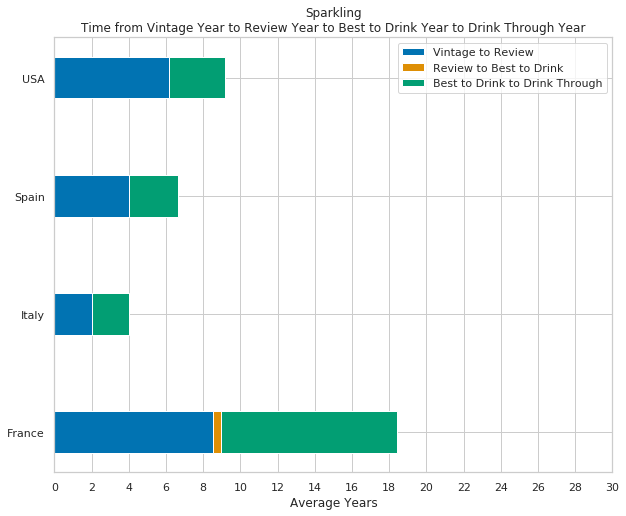

In [458]:
barh_plot_3(wine_style = 'Sparkling',
          left = 'Review_vs_Vintage', 
          mid = 'DrinkFrom_vs_Review',
          right = 'DrinkThru_vs_DrinkFrom', 
          maxyear = 32, 
          label = 'Address')

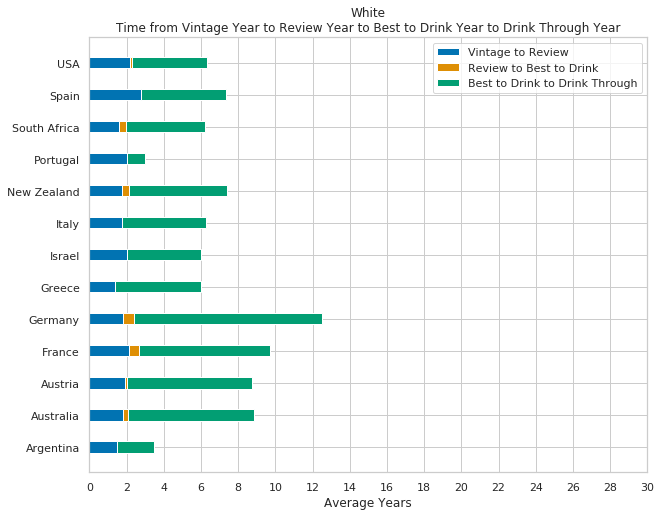

In [459]:
barh_plot_3(wine_style = 'White',
          left = 'Review_vs_Vintage', 
          mid = 'DrinkFrom_vs_Review',
          right = 'DrinkThru_vs_DrinkFrom', 
          maxyear = 32, 
          label = 'Address')